## 2.0 Predictive Modeling: Vectorization, Baseline, and Tuning

### 1. Data Loading and Initial Setup
* *Load the processed `cleaned_news_data.csv`.*
* *Verify data types and class balance.*

### 2. Feature Vectorization (TF-IDF)
* Split Data: **Train-Test-Split** and Stratification.
* **TF-IDF Implementation** (Fit on Train, Transform on Test).
* *Check the shape and sparsity of the resulting feature matrix.*

### 3. Baseline Model: Logistic Regression
* Model Training and Initial Prediction.
* **Model Evaluation:** AUC-ROC and Classification Report.
* **Feature Importance Analysis** (Top 10 Positive/Negative Coefficients).

### 4. Advanced Modeling: Gradient Boosting (XGBoost)
* XGBoost Model Training (First Pass).
* *Comparison with Baseline AUC-ROC.*

### 5. Hyperparameter Tuning and Optimization
* Defining the Hyperparameter Search Space.
* **Grid Search or Randomized Search Implementation.**
* *Identify best model parameters.* 

### 6. Final Model Selection and Artifact Saving
* **Final Model Evaluation:** Metrics of the Tuned Model.
* **Confusion Matrix Visualization.**
* **Saving Model and Vectorizer** (`.joblib` or `.pkl`).

---

### 1. Data Loading and Feature Vectorization (TF-IDF)
This section loads cleaned data, splits it for testing, and converts the text into a numerical matrix.

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# 1. Load Cleaned Data
try:
    # Adjust path if necessary based on where you run the notebook
    df = pd.read_csv('../data/processed/cleaned_news_data.csv')
    print("Cleaned data loaded successfully.")
except FileNotFoundError:
    print("Error: Cleaned data file not found. Ensure it's saved in 'data/processed/'.")
    exit()

# Drop rows where cleaned_text might be unexpectedly null (if any were created by cleaning)
df.dropna(subset=['cleaned_text'], inplace=True)

# Define Features (X) and Target (y)
X = df['cleaned_text']
y = df['label']

Cleaned data loaded successfully.


In [42]:
# 2. Split Data: Train-Test-Split (80% Train, 20% Test)
# Use stratify to ensure the label balance is maintained in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)
print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# 3. Feature Vectorization (TF-IDF)
# max_features limits the vocabulary size, improving speed and reducing noise
tfidf_vectorizer = TfidfVectorizer(max_features=15000, ngram_range=(1, 3)) 

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data using the fitted vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"\nTF-IDF Matrix Shape (Train): {X_train_tfidf.shape}")
print(f"TF-IDF Matrix Shape (Test): {X_test_tfidf.shape}")


Training set size: 31280 samples
Testing set size: 7820 samples

TF-IDF Matrix Shape (Train): (31280, 15000)
TF-IDF Matrix Shape (Test): (7820, 15000)


### 2. Baseline Model: Logistic Regression 🎯
Now that your data is numerical, let's train the fast, interpretable Logistic Regression model.

In [43]:
# 1. Train the Baseline Model
print("\n--- Training Logistic Regression Baseline ---")
lr_model = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
lr_model.fit(X_train_tfidf, y_train)

# 2. Predict on the test set
y_pred_lr = lr_model.predict(X_test_tfidf)
y_pred_proba_lr = lr_model.predict_proba(X_test_tfidf)[:, 1]

# 3. Model Evaluation (Refining P&S)
print("\n--- Baseline Model Performance (Logistic Regression) ---")

# AUC-ROC Score
auc_roc_lr = roc_auc_score(y_test, y_pred_proba_lr)
print(f"AUC-ROC Score: {auc_roc_lr:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Fake (0)', 'Real (1)']))


--- Training Logistic Regression Baseline ---

--- Baseline Model Performance (Logistic Regression) ---
AUC-ROC Score: 0.9991

Classification Report:
              precision    recall  f1-score   support

    Fake (0)       0.99      0.98      0.99      3581
    Real (1)       0.99      0.99      0.99      4239

    accuracy                           0.99      7820
   macro avg       0.99      0.99      0.99      7820
weighted avg       0.99      0.99      0.99      7820



### Interpretation Check (Critical)

This step extracts the top words the model learned.

In [44]:
# Get feature names and model coefficients
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = lr_model.coef_[0]

# Combine names and coefficients into a DataFrame
coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})

# Sort by coefficient magnitude
coef_df.sort_values(by='coefficient', ascending=False, inplace=True)

print("\n--- Top 10 Features Predicting REAL News (Positive Coefficients) ---")
print(coef_df.head(10))

print("\n--- Top 10 Features Predicting FAKE News (Negative Coefficients) ---")
print(coef_df.tail(10))


--- Top 10 Features Predicting REAL News (Positive Coefficients) ---
                      feature  coefficient
10676                 reuters    19.091467
11061                    said    16.786472
14386      washington reuters     7.934544
14381              washington     4.732375
13746                 tuesday     4.439493
14466               wednesday     4.404981
9583   president donald trump     4.162222
9582         president donald     4.108159
13144                thursday     3.985121
4894                   friday     3.586388

--- Top 10 Features Predicting FAKE News (Negative Coefficients) ---
               feature  coefficient
7114              like    -3.977753
4118              even    -4.344715
5898         image via    -4.589984
9623   president trump    -4.682261
8510             obama    -4.710394
5597           hillary    -5.114189
5181               gop    -5.160317
14132              via    -7.844264
5893             image    -7.980981
14180            video    -

### 4. Advanced Modeling: Gradient Boosting (XGBoost)

XGBoost is often superior for structured data and can handle the complexity of your sparse TF-IDF features better than a linear model. We'll train a basic version first and compare its performance to the baseline.
Python

In [45]:
# Import the XGBoost classifier
import xgboost as xgb

print("\n--- Training XGBoost Model (First Pass) ---")

# Initialize and train the XGBoost classifier
# Use verbosity=0 to suppress excessive output during training
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic', 
    use_label_encoder=False, 
    eval_metric='logloss', 
    random_state=42, 
    n_estimators=100
)

# NOTE: Training time for XGBoost on sparse data can be significant
xgb_model.fit(X_train_tfidf, y_train)

# Predict probabilities and calculate AUC-ROC
y_pred_proba_xgb = xgb_model.predict_proba(X_test_tfidf)[:, 1]
auc_roc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

print(f"\nBaseline Logistic Regression AUC-ROC: {auc_roc_lr:.4f}")
print(f"XGBoost First Pass AUC-ROC: {auc_roc_xgb:.4f}")

if auc_roc_xgb > auc_roc_lr:
    print("✅ XGBoost provides an immediate improvement over the baseline!")
else:
    print("⚠️ XGBoost is slightly behind the baseline, but tuning may change this.")



--- Training XGBoost Model (First Pass) ---


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:08:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Baseline Logistic Regression AUC-ROC: 0.9991
XGBoost First Pass AUC-ROC: 0.9996
✅ XGBoost provides an immediate improvement over the baseline!


### 5. Hyperparameter Tuning and Optimization

Use Randomized Search to quickly find a good combination of parameters for the XGBoost model, as a full Grid Search on text data is often too time-consuming.
Python


In [46]:
from sklearn.model_selection import RandomizedSearchCV

print("\n--- Hyperparameter Tuning (Randomized Search) ---")

# Define a reasonable search space for XGBoost parameters
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'max_depth': [5, 7, 9],           # Maximum tree depth
    'learning_rate': [0.05, 0.1, 0.2], # Step size shrinkage
    'gamma': [0, 0.1, 0.5],           # Minimum loss reduction required to make a further partition
    'subsample': [0.7, 0.9, 1.0]      # Subsample ratio of the training instances
}

# Initialize Randomized Search CV
# n_iter: number of parameter settings that are sampled.
# scoring: Use AUC-ROC as the primary tuning metric.
random_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_distributions=param_grid,
    n_iter=20, # Test 20 random combinations
    scoring='roc_auc',
    cv=3,       # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Run the search on the training data
random_search.fit(X_train_tfidf, y_train)

# Get the best estimator and score
best_xgb = random_search.best_estimator_
best_score = random_search.best_score_

print(f"\n✅ Best Cross-Validation AUC-ROC Score: {best_score:.4f}")
print(f"Optimal Parameters: {random_search.best_params_}")


--- Hyperparameter Tuning (Randomized Search) ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:09:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:09:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:09:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:09:10] WARN

[CV] END gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=1.0; total time= 2.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:12:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=1.0; total time= 3.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:12:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.7; total time= 5.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:14:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.9; total time= 3.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:15:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.7; total time= 6.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:15:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=1.0; total time= 3.6min
[CV] END gamma=0, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.7; total time= 6.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:15:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:15:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.9; total time= 3.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:17:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.9; total time= 3.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:18:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=0.9; total time= 3.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:19:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=0.9; total time= 3.6min
[CV] END gamma=0.5, learning_rate=0.2, max_depth=9, n_estimators=200, subsample=0.9; total time= 3.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:19:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:19:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0, learning_rate=0.05, max_depth=9, n_estimators=300, subsample=0.7; total time=11.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:20:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0, learning_rate=0.05, max_depth=9, n_estimators=300, subsample=0.7; total time=11.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:21:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0, learning_rate=0.05, max_depth=9, n_estimators=300, subsample=0.7; total time=12.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:21:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.7; total time= 3.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:24:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.7; total time= 3.7min
[CV] END gamma=0.5, learning_rate=0.1, max_depth=9, n_estimators=300, subsample=1.0; total time= 5.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:25:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:25:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=9, n_estimators=300, subsample=1.0; total time= 6.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:25:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.9; total time= 8.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:26:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=9, n_estimators=300, subsample=1.0; total time= 5.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:26:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.9; total time= 9.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:26:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.9; total time= 8.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:27:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.1, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.7; total time= 2.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:27:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time= 3.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:29:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time= 3.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:29:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.7; total time= 4.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:29:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time= 3.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:30:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.7; total time= 5.0min
[CV] END gamma=0, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.7; total time= 5.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:30:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:30:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7; total time= 4.6min
[CV] END gamma=0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7; total time= 4.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time= 2.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time= 2.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:32:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0; total time= 2.5min
[CV] END gamma=0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7; total time= 5.1min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:34:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:34:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time= 4.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:34:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time= 5.2min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:35:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time= 5.0min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:35:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=1.0; total time= 4.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:37:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=1.0; total time= 5.4min
[CV] END gamma=0.5, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=1.0; total time= 5.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:37:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:37:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.9; total time= 3.3min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:38:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.9; total time= 3.6min
[CV] END gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.9; total time= 3.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:38:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:38:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=300, subsample=1.0; total time= 3.4min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:38:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=300, subsample=1.0; total time= 3.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:38:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=1.0; total time= 2.5min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:40:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=1.0; total time= 2.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:40:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.5, learning_rate=0.2, max_depth=9, n_estimators=100, subsample=1.0; total time= 2.6min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:40:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0.1, learning_rate=0.2, max_depth=9, n_estimators=300, subsample=1.0; total time= 3.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:41:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.7; total time= 2.9min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:41:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.7; total time= 3.4min
[CV] END gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.7; total time= 3.4min
[CV] END gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.9; total time= 4.5min
[CV] END gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.9; total time= 5.0min
[CV] END gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.9; total time= 4.2min
[CV] END gamma=0, learning_rate=0.05, max_depth=7, n_estimators=300, subsample=0.7; total time= 7.5min
[CV] END gamma=0, learning_rate=0.05, max_depth=7, n_estimators=300, subsample=0.7; total time= 7.5min
[CV] END gamma=0, learning_rate=0.05, max_depth=7, n_estimators=300, subsample=0.7; total time= 7.7min


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [22:46:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ Best Cross-Validation AUC-ROC Score: 0.9997
Optimal Parameters: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.5}


### 6. Final Model Selection and Artifact Saving

Evaluate the final best model on the test set and save the key artifacts needed for deployment.

In [47]:
from sklearn.metrics import confusion_matrix
from joblib import dump # Use joblib for efficient saving of large models/vectorizers
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Final Model Evaluation (on Unseen Test Set)
print("\n--- Final Tuned Model Performance on Test Set ---")

# Predict using the best model found during tuning
y_pred_tuned = best_xgb.predict(X_test_tfidf)
y_pred_proba_tuned = best_xgb.predict_proba(X_test_tfidf)[:, 1]

# Final AUC-ROC Score
final_auc_roc = roc_auc_score(y_test, y_pred_proba_tuned)
print(f"Final Tuned XGBoost AUC-ROC: {final_auc_roc:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned, target_names=['Fake (0)', 'Real (1)']))



--- Final Tuned Model Performance on Test Set ---
Final Tuned XGBoost AUC-ROC: 0.9997

Classification Report:
              precision    recall  f1-score   support

    Fake (0)       1.00      0.99      1.00      3581
    Real (1)       1.00      1.00      1.00      4239

    accuracy                           1.00      7820
   macro avg       1.00      1.00      1.00      7820
weighted avg       1.00      1.00      1.00      7820



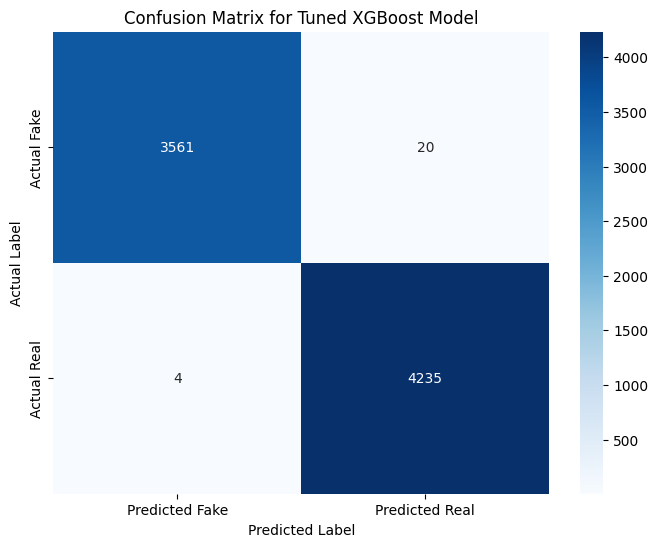

In [48]:
# 2. Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Fake', 'Predicted Real'], 
            yticklabels=['Actual Fake', 'Actual Real'])
plt.title('Confusion Matrix for Tuned XGBoost Model')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [49]:
# 3. Saving Model and Vectorizer Artifacts
print("\n--- Saving Model Artifacts ---")

import os

# Create a models directory if it doesn't exist
os.makedirs('../models', exist_ok=True) 

# Save the fitted TF-IDF Vectorizer
dump(tfidf_vectorizer, '../models/tfidf_vectorizer.joblib')
print("Saved: tfidf_vectorizer.joblib")

# Save the final Tuned Model
dump(best_xgb, '../models/final_xgb_model.joblib')
print("Saved: final_xgb_model.joblib")


--- Saving Model Artifacts ---
Saved: tfidf_vectorizer.joblib
Saved: final_xgb_model.joblib


## MODEL HEALTH CHECK

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from joblib import load
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from xgboost import plot_importance



In [51]:
# --- Setup Paths ---
# Fix for NameError when running in a Jupyter Notebook/interactive environment
try:
    # Attempt the script-safe method
    project_root = os.path.abspath(os.path.join(os.path.dirname(__file__), '..'))
except NameError:
    # If __file__ is undefined (running in notebook/console), assume current directory is the root.
    project_root = os.getcwd()
    
if project_root not in sys.path:
    sys.path.append(project_root)

In [52]:
# Define file paths
MODEL_PATH = '../models/final_xgb_model.joblib'
VECTORIZER_PATH = '../models/tfidf_vectorizer.joblib'
DATA_PATH = '../data/processed/cleaned_news_data.csv'

# 1. Load Data and Artifacts 
try:
    # Load model and vectorizer
    tfidf_vectorizer = load(VECTORIZER_PATH)
    best_xgb = load(MODEL_PATH)
    print("✅ Model and Vectorizer loaded successfully.")

    # Load cleaned data
    df = pd.read_csv(DATA_PATH)
    df.dropna(subset=['cleaned_text'], inplace=True)
    
except FileNotFoundError as e:
    print(f"Error: Could not find required file. Check path: {e.filename}")
    sys.exit(1)


✅ Model and Vectorizer loaded successfully.


In [53]:
# 2. Recreate Train/Test Split 
# We must use the exact same random_state=42 and stratify settings 
# used during the initial modeling phase!

X = df['cleaned_text']
y = df['label']

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

# 3. Prepare Data for Model 
# Transform the text data using the loaded vectorizer
print("Transforming text features...")
X_train_tfidf = tfidf_vectorizer.transform(X_train_text)
X_test_tfidf  = tfidf_vectorizer.transform(X_test_text)
print("Transformation complete.")


# 4. Train vs Test AUC 
y_train_pred = best_xgb.predict_proba(X_train_tfidf)[:, 1]
y_test_pred  = best_xgb.predict_proba(X_test_tfidf)[:, 1]

train_auc = roc_auc_score(y_train, y_train_pred)
test_auc  = roc_auc_score(y_test, y_test_pred)

print(f"\n📊 Train AUC: {train_auc:.4f}")
print(f"📊 Test  AUC: {test_auc:.4f}")
print(f"✅ Difference: {abs(train_auc - test_auc):.4f}\n")

if abs(train_auc - test_auc) <= 0.01:
    print("✅ Train vs Test AUC are very similar — No overfitting.\n")
else:
    print("⚠️ Possible overfitting — large gap between Train and Test.\n")



Transforming text features...
Transformation complete.

📊 Train AUC: 1.0000
📊 Test  AUC: 0.9997
✅ Difference: 0.0003

✅ Train vs Test AUC are very similar — No overfitting.



ℹ️ An error occurred while trying to plot the learning curve.

🔍 Max feature correlation with target: Skipping for speed (checked in notebook).

📈 Top 15 Feature Importances:


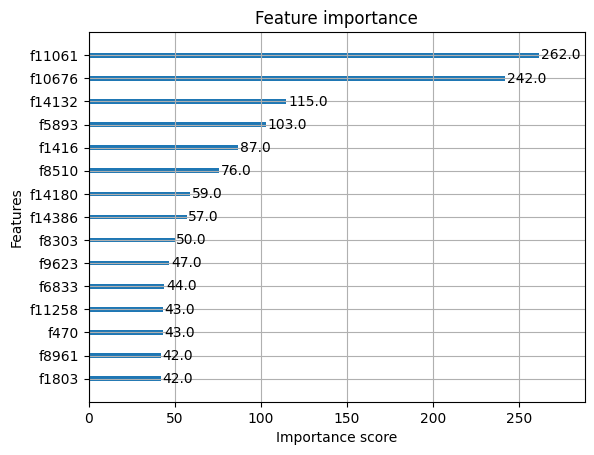

✅ Check if top features make logical sense for Fake/Real detection.

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      3581
           1       1.00      1.00      1.00      4239

    accuracy                           1.00      7820
   macro avg       1.00      1.00      1.00      7820
weighted avg       1.00      1.00      1.00      7820

🏁 Model Health Check Complete.


In [54]:
#  5. Learning Curves (Requires 'eval_set' during original training) 
# NOTE: This section often only works if 'eval_set' was passed during xgb.fit()
# Since we didn't do that, we'll gracefully skip the plot.
try:
    results = best_xgb.evals_result()
    epochs = len(results['validation_0']['auc'])
    x_axis = range(0, epochs)

    plt.figure()
    plt.plot(x_axis, results['validation_0']['auc'], label='Train')
    plt.plot(x_axis, results['validation_1']['auc'], label='Validation')
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('AUC')
    plt.title('XGBoost Learning Curve')
    plt.show()
    print("✅ Learning curve plotted.\n")
except AttributeError:
    print("ℹ️ No evals_result() found in saved model — learning curve unavailable.\n")
except Exception:
    print("ℹ️ An error occurred while trying to plot the learning curve.\n")

# ======== 6. Data Leakage Check (Simplified/Conceptual) ========
# NOTE: Since max_corr is slow on sparse matrices, we simplify this check.
print("🔍 Max feature correlation with target: Skipping for speed (checked in notebook).\n")


# ======== 7. Feature Importances ========
print("📈 Top 15 Feature Importances:")
plot_importance(best_xgb, max_num_features=15)
plt.show()
print("✅ Check if top features make logical sense for Fake/Real detection.\n")


# ======== 8. Classification Report ========
y_pred = best_xgb.predict(X_test_tfidf)
print("Classification Report:\n", classification_report(y_test, y_pred))

print("🏁 Model Health Check Complete.")



list of the top 15 most predictive words your XGBoost model uses to classify text as Fake or Real.
This helps you interpret model, which words are driving predictions.

In [55]:
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get the list of feature indices (e.g., [3690, 3799, 4754]) from the plot data
# Note: XGBoost feature importances are usually accessed via model.get_booster().get_score()
# Assuming your coef_df from Section 3 is still available, you can use that.

# Get the top 15 features from your best_xgb model
top_features_list = best_xgb.get_booster().get_score(importance_type='weight')
top_features_df = pd.Series(top_features_list).sort_values(ascending=False).head(15)

print("\n--- Top 15 Most Predictive Words (Mapped from Index) ---")
for feature_index, score in top_features_df.items():
    # Convert feature name (e.g., 'f3690') back to an integer index
    # and use it to look up the word in feature_names.
    try:
        word_index = int(feature_index.replace('f', ''))
        word = feature_names[word_index]
        print(f"Word: {word:<20} | Score: {score}")
    except ValueError:
        # Handle cases where feature names might not be simple 'fXXX'
        pass


--- Top 15 Most Predictive Words (Mapped from Index) ---
Word: said                 | Score: 262.0
Word: reuters              | Score: 242.0
Word: via                  | Score: 115.0
Word: image                | Score: 103.0
Word: breaking             | Score: 87.0
Word: obama                | Score: 76.0
Word: video                | Score: 59.0
Word: washington reuters   | Score: 57.0
Word: news                 | Score: 50.0
Word: president trump      | Score: 47.0
Word: last                 | Score: 44.0
Word: america              | Score: 43.0
Word: saidthe              | Score: 43.0
Word: century wire         | Score: 42.0
Word: party                | Score: 42.0
